# Building SGAN for missing labelled datas

## Investigating accuracy with 100 labelled data

In [216]:
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint

import tensorflow as tf

from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, GlobalAveragePooling2D
from keras.layers import LeakyReLU, Dropout, Lambda, Activation

from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset prepration

In [100]:
# Get images ready by loading and preprocessing.
def get_images_ready(n_classes=10):
    (trainX, trainy), (_, _) = load_data()
    # X = np.expand_dims(trainX, axis=-1)
    X = trainX.astype('float32')
    X = X/255.  # scale from [0,255] to [0,1]
    print(X.shape, trainy.shape)
    return [X, trainy]

#Pick a subset of images.
num_images = 120
def select_subset_images(dataset, n_samples=num_images, n_classes=10):
  X, y = dataset
  X_list, y_list = list(), list()
  n_per_class = int(n_samples / n_classes) #Number of samples per class.
  y = np.squeeze(y)
  for i in range(n_classes):
          X_with_class = X[y == i] # get all images for this class
          # print(X_with_class.shape)
          ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
          [X_list.append(X_with_class[j]) for j in ix] # add to list
          [y_list.append(i) for j in ix]
  return np.asarray(X_list), np.asarray(y_list) #Returns a list of 2 numpy arrays corresponding to X and Y

#Define the dataset.
dataset = get_images_ready()
#Get subset images and corresponding labels
X, Y = select_subset_images(dataset)

(50000, 32, 32, 3) (50000, 1)


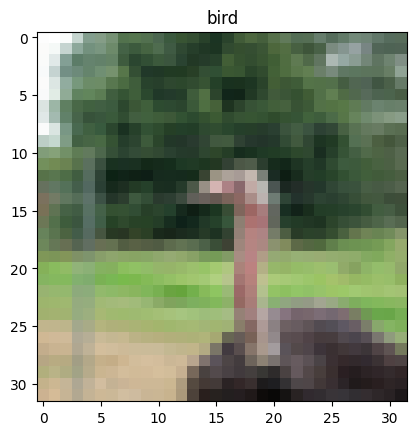

In [110]:
#View some random images
classes = ['airplane', 'automobile', 'bird',	'cat', 'deer',	'dog',	'frog',	'horse',	'ship',	'truck']
i = randint(0, X.shape[0])
plt.title(classes[Y[i]])
plt.imshow(X[i])

### Model

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#### NOTE: We will be using sparse_categorical_crossentropy loss so we will not convert Y to categorical ####

#Define Model with BatchNormalization and Dropout
# define cnn model

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu'))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
	# compile model
#opt = SGD(lr=0.01, momentum=0.9)
opt = Adam(lr=0.0002, beta_1=0.5)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define model
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 15, 15, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
Total params: 113738 (444.29 KB)
Trainable params: 113

In [221]:
resnet50 = tf.keras.applications.ResNet50(weights='imagenet', input_shape=(32,32,3), include_top=False)
resnet50.trainable = False

In [233]:
# model_with_resnet = Sequential([
#     # Input(shape= (32,32,3)),
#     resnet50,
#     GlobalAveragePooling2D(),
#     Dense(1024, activation='relu'),
#     Dense(10, activation='softmax')
# ])

# model_with_resnet.summary()

input = Input(shape=(32,32,3))
x = resnet50(input, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

fine_tuned_model = Model(input,output)
# fine_tuned_model.summary()

### Training

In [112]:
history = model.fit(X_train, y_train,
                    epochs=100, batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/100
2/2 [==============================] - 1s 220ms/step - loss: 2.4009 - accuracy: 0.0938 - val_loss: 2.3334 - val_accuracy: 0.0833
Epoch 2/100
2/2 [==============================] - 0s 57ms/step - loss: 2.2706 - accuracy: 0.1146 - val_loss: 2.3532 - val_accuracy: 0.1667
Epoch 3/100
2/2 [==============================] - 0s 55ms/step - loss: 2.2371 - accuracy: 0.1667 - val_loss: 2.3264 - val_accuracy: 0.1667
Epoch 4/100
2/2 [==============================] - 0s 55ms/step - loss: 2.1930 - accuracy: 0.2292 - val_loss: 2.3556 - val_accuracy: 0.1667
Epoch 5/100
2/2 [==============================] - 0s 62ms/step - loss: 2.0997 - accuracy: 0.2917 - val_loss: 2.3158 - val_accuracy: 0.1250
Epoch 6/100
2/2 [==============================] - 0s 76ms/step - loss: 2.0379 - accuracy: 0.3958 - val_loss: 2.2090 - val_accuracy: 0.2083
Epoch 7/100
2/2 [==============================] - 0s 52ms/step - loss: 1.9775 - accuracy: 0.3958 - val_loss: 2.1709 - val_accuracy: 0.2083
Epoch 8/100
2/2 [==

In [113]:
model.save('/content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/cnn_model_for_mnist_100epochs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [234]:
fine_tuned_model.compile(optimizer=Adam(learning_rate=.0002, beta_1=.5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fine_tuned_history = fine_tuned_model.fit(X_train, y_train,
#                      epochs = 100, batch_size=64,
#                      validation_data=(X_test, y_test),
#                      verbose=1)
# y_pred = fine_tuned_model.predict(X[i])

Epoch 1/100
2/2 [==============================] - 7s 2s/step - loss: 2.9210 - accuracy: 0.0729 - val_loss: 2.7262 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 1s 332ms/step - loss: 2.4086 - accuracy: 0.1354 - val_loss: 2.5021 - val_accuracy: 0.0417
Epoch 3/100
2/2 [==============================] - 1s 299ms/step - loss: 2.3120 - accuracy: 0.1354 - val_loss: 2.4167 - val_accuracy: 0.0417
Epoch 4/100
2/2 [==============================] - 1s 593ms/step - loss: 2.2907 - accuracy: 0.0833 - val_loss: 2.4880 - val_accuracy: 0.0833
Epoch 5/100
2/2 [==============================] - 1s 602ms/step - loss: 2.3127 - accuracy: 0.1562 - val_loss: 2.5368 - val_accuracy: 0.0417
Epoch 6/100
2/2 [==============================] - 1s 474ms/step - loss: 2.2998 - accuracy: 0.1042 - val_loss: 2.5428 - val_accuracy: 0.0417
Epoch 7/100
2/2 [==============================] - 1s 600ms/step - loss: 2.2866 - accuracy: 0.1250 - val_loss: 2.4034 - val_accuracy: 0.1250
Epoch 8/100


### Plotting

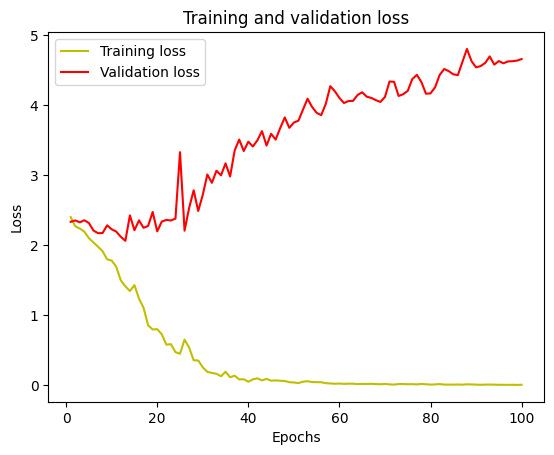

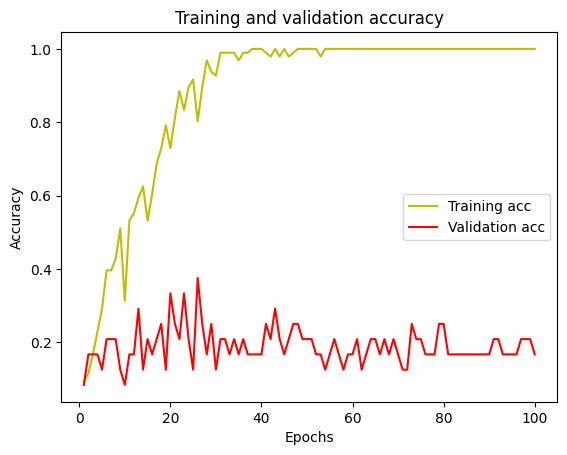

In [114]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

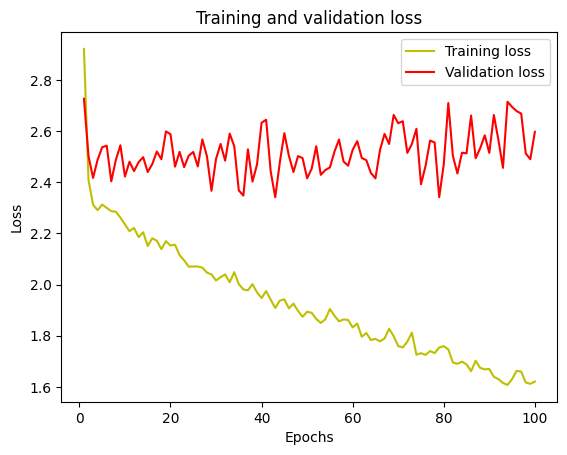

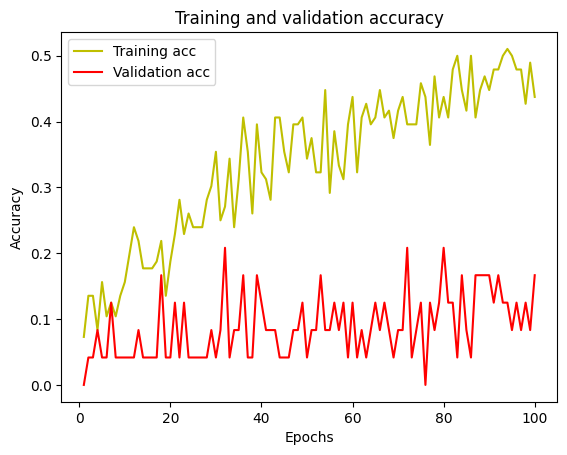

In [235]:
loss = fine_tuned_history.history['loss']
val_loss = fine_tuned_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = fine_tuned_history.history['accuracy']
val_acc = fine_tuned_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Test Accuracy without fine-tune: 26.040%
313/313 [==============================] - 2s 7ms/step


<Axes: >

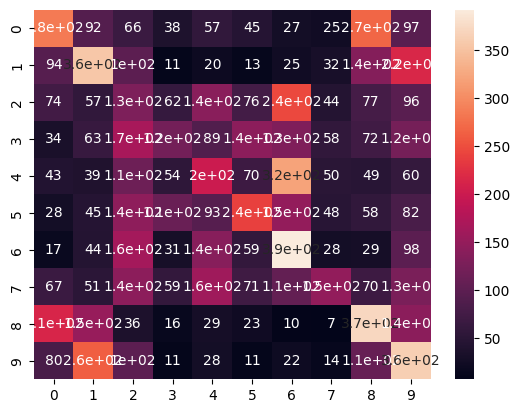

In [237]:
#Test the model on all test data - 10,000 images

from keras.models import load_model
# load the model
my_model = load_model('/content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/cnn_model_for_mnist_100epochs.h5')

# load the dataset
(_, _), (test_X, test_y) = load_data()

# expand to 3d, e.g. add channels
test_X = np.expand_dims(test_X, axis=-1)

# convert from ints to floats
test_X = test_X.astype('float32')

# scale from [0,255] to [-1,1]
test_X = test_X /255.

# evaluate the model
_, test_acc = my_model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy without fine-tune: %.3f%%' % (test_acc * 100))


# Predicting the Test set results
y_pred_test = my_model.predict(test_X)
prediction_test = np.argmax(y_pred_test, axis=1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_y, prediction_test)
sns.heatmap(cm, annot=True)

## Building SGAN

### Model

#### Generator

In [191]:
def define_generator(latent_dim):

	in_lat = Input(shape=(latent_dim,))
	#Start with enough dense nodes to be reshaped and ConvTransposed to 32x32x3
	n_nodes = 256 * 8 * 8
	X = Dense(n_nodes)(in_lat)
	X = LeakyReLU(alpha=0.2)(X)
	X = Reshape((8, 8, 256))(X)

	X = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(X) #16x16x128
	X = LeakyReLU(alpha=0.2)(X)

	X = Conv2DTranspose(64, (3,3), strides=(1,1), padding='same')(X) #16x16x64
	X = LeakyReLU(alpha=0.2)(X)
	# output
	out_layer = Conv2DTranspose(3, (3,3), strides=(2,2), activation='tanh',
                             padding='same')(X) #32x32x3
	# define model
	model = Model(in_lat, out_layer)
	return model

gen_model=define_generator(100)
print(gen_model.summary())

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_44 (Dense)            (None, 16384)             1654784   
                                                                 
 leaky_re_lu_115 (LeakyReLU  (None, 16384)             0         
 )                                                               
                                                                 
 reshape_21 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_60 (Conv2  (None, 16, 16, 128)       295040    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_116 (LeakyReLU  (None, 16, 16, 128)       0  

#### Discriminator

In [192]:
def define_discriminator(in_shape=(32,32,3), n_classes=10):
    in_image = Input(shape=in_shape)
    X = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(64, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X)
    X = Dropout(0.4)(X) #Consider adding more dropout layers to minimize overfitting - remember we work with limited labeled data.
    X = Dense(n_classes)(X)

    model = Model(inputs=in_image, outputs=X)

    return model

disc_model = define_discriminator()
disc_model.summary()

Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_118 (LeakyReLU  (None, 16, 16, 32)        0         
 )                                                               
                                                                 
 conv2d_70 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 leaky_re_lu_119 (LeakyReLU  (None, 8, 8, 64)          0         
 )                                                               
                                                                 
 conv2d_71 (Conv2D)          (None, 4, 4, 128)         738

#### Supervised Discriminator

In [193]:
def define_sup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Activation('softmax'))
    #Let us use sparse categorical loss so we dont have to convert our Y to categorical
    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5),
                  loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    return model

sup_disc_model = define_sup_discriminator(disc_model)
sup_disc_model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_56 (Functional)       (None, 10)                113738    
                                                                 
 activation_17 (Activation)  (None, 10)                0         
                                                                 
Total params: 113738 (444.29 KB)
Trainable params: 113738 (444.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unsupervised Discriminator

In [194]:
def custom_activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x /(Z_x+1)

    return D_x

#You can also try the built in tensorflow function: tf.reduce_logsumexp(class_logits, 1)

def define_unsup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Lambda(custom_activation))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

unsup_disc_model = define_unsup_discriminator(disc_model)
unsup_disc_model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_56 (Functional)       (None, 10)                113738    
                                                                 
 lambda_17 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 113738 (444.29 KB)
Trainable params: 113738 (444.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### GAN

In [195]:
def define_gan(gen_model, disc_unsup):

	disc_unsup.trainable = False # make unsup. discriminator not trainable
	gan_output = disc_unsup(gen_model.output) #Gen. output is the input to disc.
	model = Model(gen_model.input, gan_output)
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

gan_model = define_gan(gen_model, unsup_disc_model)
print(gan_model.summary())

Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_44 (Dense)            (None, 16384)             1654784   
                                                                 
 leaky_re_lu_115 (LeakyReLU  (None, 16384)             0         
 )                                                               
                                                                 
 reshape_21 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_60 (Conv2  (None, 16, 16, 128)       295040    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_116 (LeakyReLU  (None, 16, 16, 128)       0  

### Dataset Prepration

In [184]:
def load_real_samples(n_classes=10):
  (trainX, trainy), (_, _) = load_data()
  # X = expand_dims(trainX, axis=-1)
  X = trainX.astype('float32')
  X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1] as we will be using tanh activation.
  print(X.shape, trainy.shape)
  return [X, trainy]

# data = load_real_samples()

def select_supervised_samples(dataset, n_samples=100, n_classes=10):
  X, y = dataset
  y = np.squeeze(y)
  X_list, y_list = list(), list()
  n_per_class = int(n_samples / n_classes) #Number of amples per class.
  for i in range(n_classes):
          X_with_class = X[y == i] # get all images for this class
          ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
          [X_list.append(X_with_class[j]) for j in ix] # add to list
          [y_list.append(i) for j in ix]
  return asarray(X_list), asarray(y_list) #Returns a list of 2 numpy arrays corresponding to X and Y

def generate_real_samples(dataset, n_samples):

	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix] #Select random images and corresponding labels
	y = ones((n_samples, 1)) #Label all images as 1 as these are real images. (for the discriminator training)
	return [X, labels], y

# generate latent points, to be used as inputs to the generator.
def generate_latent_points(latent_dim, n_samples):
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim) # reshape for input to the network
	return z_input

def generate_fake_samples(generator, latent_dim, n_samples):

	z_input = generate_latent_points(latent_dim, n_samples)
	fake_images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1)) #Label all images as 0 as these are fake images. (for the discriminator training)
	return fake_images, y

# report accuracy and save plots & the model periodically.
def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
	# Generate fake images
	# X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)

	# X = (X + 1) / 2.0 # scale to [0,1] for plotting
	# plot images
	# for i in range(100):
		# plt.subplot(10, 10, 1 + i)
		# plt.axis('off')
		# plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to drive
	filename1 = '/content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png'
	# plt.savefig(filename1)
	# plt.close()

	# evaluate the discriminator
	X, y = dataset
	# _, acc = disc_sup.evaluate(X, y, verbose=0)
	# print('Discriminator Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = '/content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5'
	gen_model.save(filename2)
	# save the Discriminator (classifier) model
	filename3 = '/content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5'
	disc_sup.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

### Training

In [200]:
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
  X_sup, y_sup = select_supervised_samples(dataset)
  #print(X_sup.shape, y_sup.shape)

  bat_per_epo = int(dataset[0].shape[0] / n_batch)

  n_steps = bat_per_epo * n_epochs

  half_batch = int(n_batch / 2)
  print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
  last_loss = .0

  for i in range(n_steps):
    [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
    sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)

    [X_real, _], y_real = generate_real_samples(dataset, half_batch)
    d_loss_real = disc_unsup.train_on_batch(X_real, y_real)

    X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
    d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)

    X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
    gan_loss = gan_model.train_on_batch(X_gan, y_gan)

    print('>%d, sup[loss: %.3f, acc: %.0f], disc[loss real: %.3f, loss fake: %.3f], gan[loss: %.3f]' % (i+1, sup_loss, sup_acc*100, d_loss_real, d_loss_fake, gan_loss))

    # if (i+1) % (bat_per_epo * 1) == 0:
    if sup_loss >= last_loss:
      last_loss = sup_loss
      summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)

latent_dim = 100


disc=define_discriminator() #Bare discriminator model...
disc_sup=define_sup_discriminator(disc) #Supervised discriminator model
disc_unsup=define_unsup_discriminator(disc) #Unsupervised discriminator model.

gen_model = define_generator(latent_dim) #Generator
gan_model = define_gan(gen_model, disc_unsup) #GAN
dataset = load_real_samples() #Define the dataset by loading real samples. (This will be a list of 2 numpy arrays, X and y)

train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=10, n_batch=100)

(50000, 32, 32, 3) (50000, 1)
n_epochs=10, n_batch=100, 1/2=50, b/e=500, steps=5000
2/2 [==============================] - 0s 45ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>1, sup[loss: 2.288, acc: 10], disc[loss real: 0.095, loss fake: 2.406], gan[loss: 0.095]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 75ms/step


>2, sup[loss: 2.296, acc: 20], disc[loss real: 0.088, loss fake: 2.405], gan[loss: 0.096]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 73ms/step


>3, sup[loss: 2.266, acc: 20], disc[loss real: 0.084, loss fake: 2.405], gan[loss: 0.096]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 75ms/step


>4, sup[loss: 2.196, acc: 26], disc[loss real: 0.079, loss fake: 2.410], gan[loss: 0.098]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step
>5, sup[loss: 2.180, acc: 24], disc[loss real: 0.070, loss fake: 2.388], gan[loss: 0.103]
2/2 [==============================] - 0s 46ms/step


>6, sup[loss: 2.106, acc: 30], disc[loss real: 0.062, loss fake: 2.352], gan[loss: 0.105]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 45ms/step
>7, sup[loss: 2.186, acc: 18], disc[loss real: 0.046, loss fake: 2.356], gan[loss: 0.106]
2/2 [==============================] - 0s 44ms/step
>8, sup[loss: 2.160, acc: 20], disc[loss real: 0.041, loss fake: 2.370], gan[loss: 0.110]
2/2 [==============================] - 0s 57ms/step
>9, sup[loss: 1.909, acc: 28], disc[loss real: 0.028, loss fake: 2.309], gan[loss: 0.129]
2/2 [==============================] - 0s 46ms/step
>10, sup[loss: 1.978, acc: 20], disc[loss real: 0.023, loss fake: 2.108], gan[loss: 0.159]
2/2 [==============================] - 0s 47ms/step
>11, sup[loss: 2.196, acc: 16], disc[loss real: 0.017, loss fake: 2.0

>12, sup[loss: 1.753, acc: 36], disc[loss real: 0.009, loss fake: 1.826], gan[loss: 0.260]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 52ms/step


>13, sup[loss: 1.650, acc: 38], disc[loss real: 0.010, loss fake: 1.371], gan[loss: 0.657]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>14, sup[loss: 1.967, acc: 40], disc[loss real: 0.065, loss fake: 0.673], gan[loss: 1.532]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 86ms/step


>15, sup[loss: 1.782, acc: 46], disc[loss real: 0.047, loss fake: 0.246], gan[loss: 2.359]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 71ms/step


>16, sup[loss: 1.479, acc: 54], disc[loss real: 0.075, loss fake: 0.102], gan[loss: 3.195]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 73ms/step
>17, sup[loss: 1.907, acc: 36], disc[loss real: 0.073, loss fake: 0.156], gan[loss: 3.635]
2/2 [==============================] - 0s 46ms/step


>18, sup[loss: 1.509, acc: 54], disc[loss real: 0.030, loss fake: 0.310], gan[loss: 7.254]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step
>19, sup[loss: 1.368, acc: 48], disc[loss real: 0.028, loss fake: 0.001], gan[loss: 8.704]
2/2 [==============================] - 0s 48ms/step
>20, sup[loss: 1.551, acc: 46], disc[loss real: 0.457, loss fake: 0.078], gan[loss: 5.979]
2/2 [==============================] - 0s 48ms/step
>21, sup[loss: 1.897, acc: 42], disc[loss real: 0.064, loss fake: 0.034], gan[loss: 6.499]
2/2 [==============================] - 0s 55ms/step


>22, sup[loss: 1.527, acc: 60], disc[loss real: 0.009, loss fake: 0.042], gan[loss: 8.082]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>23, sup[loss: 1.431, acc: 50], disc[loss real: 0.068, loss fake: 0.417], gan[loss: 5.599]
2/2 [==============================] - 0s 46ms/step


>24, sup[loss: 1.153, acc: 66], disc[loss real: 0.798, loss fake: 6.494], gan[loss: 5.338]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step


>25, sup[loss: 1.230, acc: 66], disc[loss real: 0.111, loss fake: 0.149], gan[loss: 5.958]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step
>26, sup[loss: 1.358, acc: 50], disc[loss real: 0.232, loss fake: 2.392], gan[loss: 8.812]
2/2 [==============================] - 0s 47ms/step
>27, sup[loss: 1.231, acc: 60], disc[loss real: 0.266, loss fake: 0.226], gan[loss: 8.184]
2/2 [==============================] - 0s 47ms/step


>28, sup[loss: 1.043, acc: 68], disc[loss real: 0.339, loss fake: 1.436], gan[loss: 7.878]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 84ms/step


>29, sup[loss: 1.055, acc: 68], disc[loss real: 0.455, loss fake: 2.103], gan[loss: 3.930]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 75ms/step


>30, sup[loss: 1.059, acc: 68], disc[loss real: 0.104, loss fake: 8.778], gan[loss: 2.747]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 67ms/step
>31, sup[loss: 1.393, acc: 50], disc[loss real: 0.680, loss fake: 5.200], gan[loss: 5.965]
2/2 [==============================] - 0s 46ms/step
>32, sup[loss: 1.362, acc: 48], disc[loss real: 1.360, loss fake: 0.793], gan[loss: 4.089]
2/2 [==============================] - 0s 46ms/step
>33, sup[loss: 1.468, acc: 48], disc[loss real: 0.923, loss fake: 0.748], gan[loss: 2.162]
2/2 [==============================] - 0s 48ms/step
>34, sup[loss: 1.269, acc: 56], disc[loss real: 0.464, loss fake: 0.536], gan[loss: 2.781]
2/2 [==============================] - 0s 47ms/step
>35, sup[loss: 1.164, acc: 54], disc[loss real: 0.365, loss fake:

>37, sup[loss: 0.942, acc: 70], disc[loss real: 0.490, loss fake: 0.532], gan[loss: 3.979]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 63ms/step
>38, sup[loss: 1.182, acc: 68], disc[loss real: 0.547, loss fake: 0.408], gan[loss: 3.354]
2/2 [==============================] - 0s 47ms/step


>39, sup[loss: 0.863, acc: 78], disc[loss real: 0.364, loss fake: 0.476], gan[loss: 3.101]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>40, sup[loss: 0.905, acc: 66], disc[loss real: 0.378, loss fake: 0.310], gan[loss: 3.098]
2/2 [==============================] - 0s 47ms/step
>41, sup[loss: 1.085, acc: 62], disc[loss real: 0.272, loss fake: 0.620], gan[loss: 3.768]
2/2 [==============================] - 0s 76ms/step
>42, sup[loss: 0.944, acc: 70], disc[loss real: 0.456, loss fake: 0.421], gan[loss: 3.488]
2/2 [==============================] - 0s 82ms/step
>43, sup[loss: 0.984, acc: 74], disc[loss real: 0.283, loss fake: 0.478], gan[loss: 2.937]
2/2 [==============================] - 0s 75ms/step
>44, sup[loss: 0.792, acc: 76], disc[loss real: 0.448, loss fake:

>48, sup[loss: 0.867, acc: 78], disc[loss real: 0.652, loss fake: 0.760], gan[loss: 2.631]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 62ms/step


>49, sup[loss: 0.702, acc: 78], disc[loss real: 0.950, loss fake: 0.464], gan[loss: 2.396]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>50, sup[loss: 0.696, acc: 84], disc[loss real: 0.679, loss fake: 0.762], gan[loss: 2.785]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>51, sup[loss: 0.556, acc: 88], disc[loss real: 0.333, loss fake: 0.224], gan[loss: 2.633]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step
>52, sup[loss: 0.746, acc: 80], disc[loss real: 0.594, loss fake: 1.224], gan[loss: 3.388]
2/2 [==============================] - 0s 58ms/step
>53, sup[loss: 0.633, acc: 86], disc[loss real: 0.823, loss fake: 0.775], gan[loss: 3.516]
2/2 [==============================] - 0s 46ms/step
>54, sup[loss: 0.619, acc: 84], disc[loss real: 1.052, loss fake: 1.302], gan[loss: 3.057]
2/2 [==============================] - 0s 76ms/step


>55, sup[loss: 0.582, acc: 88], disc[loss real: 0.721, loss fake: 0.758], gan[loss: 3.298]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 76ms/step
>56, sup[loss: 0.510, acc: 84], disc[loss real: 1.113, loss fake: 1.505], gan[loss: 3.044]
2/2 [==============================] - 0s 74ms/step
>57, sup[loss: 0.679, acc: 74], disc[loss real: 1.374, loss fake: 1.501], gan[loss: 2.763]
2/2 [==============================] - 0s 46ms/step
>58, sup[loss: 0.832, acc: 72], disc[loss real: 0.996, loss fake: 1.043], gan[loss: 2.470]
2/2 [==============================] - 0s 50ms/step


>59, sup[loss: 0.539, acc: 88], disc[loss real: 1.889, loss fake: 1.348], gan[loss: 1.437]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step
>60, sup[loss: 0.715, acc: 78], disc[loss real: 1.663, loss fake: 1.260], gan[loss: 1.389]
2/2 [==============================] - 0s 56ms/step
>61, sup[loss: 0.661, acc: 82], disc[loss real: 0.977, loss fake: 0.713], gan[loss: 1.726]
2/2 [==============================] - 0s 56ms/step
>62, sup[loss: 0.669, acc: 84], disc[loss real: 0.858, loss fake: 0.670], gan[loss: 1.483]
2/2 [==============================] - 0s 49ms/step
>63, sup[loss: 0.659, acc: 82], disc[loss real: 0.801, loss fake: 0.809], gan[loss: 1.504]
2/2 [==============================] - 0s 47ms/step
>64, sup[loss: 0.661, acc: 80], disc[loss real: 0.540, loss fake:

>66, sup[loss: 0.462, acc: 90], disc[loss real: 0.799, loss fake: 0.920], gan[loss: 1.550]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step


>67, sup[loss: 0.544, acc: 90], disc[loss real: 0.655, loss fake: 0.971], gan[loss: 1.738]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step
>68, sup[loss: 0.416, acc: 88], disc[loss real: 1.089, loss fake: 0.864], gan[loss: 1.584]
2/2 [==============================] - 0s 80ms/step
>69, sup[loss: 0.638, acc: 82], disc[loss real: 1.141, loss fake: 0.726], gan[loss: 1.407]
2/2 [==============================] - 0s 70ms/step


>70, sup[loss: 0.370, acc: 96], disc[loss real: 0.797, loss fake: 0.870], gan[loss: 1.476]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 76ms/step
>71, sup[loss: 0.514, acc: 90], disc[loss real: 0.661, loss fake: 0.653], gan[loss: 1.411]
2/2 [==============================] - 0s 46ms/step
>72, sup[loss: 0.464, acc: 92], disc[loss real: 0.735, loss fake: 0.973], gan[loss: 1.195]
2/2 [==============================] - 0s 49ms/step
>73, sup[loss: 0.581, acc: 84], disc[loss real: 0.904, loss fake: 0.798], gan[loss: 1.235]
2/2 [==============================] - 0s 46ms/step
>74, sup[loss: 0.472, acc: 84], disc[loss real: 0.608, loss fake: 0.733], gan[loss: 1.101]
2/2 [==============================] - 0s 46ms/step
>75, sup[loss: 0.472, acc: 90], disc[loss real: 0.745, loss fake:

>76, sup[loss: 0.304, acc: 98], disc[loss real: 0.838, loss fake: 0.869], gan[loss: 0.967]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>77, sup[loss: 0.501, acc: 88], disc[loss real: 0.587, loss fake: 0.784], gan[loss: 0.967]
2/2 [==============================] - 0s 50ms/step
>78, sup[loss: 0.334, acc: 90], disc[loss real: 0.450, loss fake: 0.785], gan[loss: 1.189]
2/2 [==============================] - 0s 47ms/step
>79, sup[loss: 0.555, acc: 82], disc[loss real: 0.947, loss fake: 0.809], gan[loss: 1.096]
2/2 [==============================] - 0s 46ms/step
>80, sup[loss: 0.528, acc: 88], disc[loss real: 0.587, loss fake: 0.789], gan[loss: 1.081]
2/2 [==============================] - 0s 46ms/step
>81, sup[loss: 0.246, acc: 96], disc[loss real: 0.612, loss fake:

>84, sup[loss: 0.228, acc: 98], disc[loss real: 0.850, loss fake: 1.085], gan[loss: 0.856]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 58ms/step
>85, sup[loss: 0.281, acc: 96], disc[loss real: 0.800, loss fake: 0.967], gan[loss: 0.920]
2/2 [==============================] - 0s 47ms/step
>86, sup[loss: 0.363, acc: 92], disc[loss real: 0.707, loss fake: 1.116], gan[loss: 1.017]
2/2 [==============================] - 0s 48ms/step
>87, sup[loss: 0.356, acc: 86], disc[loss real: 0.751, loss fake: 0.918], gan[loss: 1.249]
2/2 [==============================] - 0s 48ms/step
>88, sup[loss: 0.323, acc: 92], disc[loss real: 1.033, loss fake: 0.681], gan[loss: 1.178]
2/2 [==============================] - 0s 59ms/step
>89, sup[loss: 0.311, acc: 96], disc[loss real: 0.658, loss fake:

>100, sup[loss: 0.140, acc: 100], disc[loss real: 0.737, loss fake: 1.249], gan[loss: 1.161]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 53ms/step
>101, sup[loss: 0.315, acc: 92], disc[loss real: 0.911, loss fake: 0.861], gan[loss: 1.090]
2/2 [==============================] - 0s 48ms/step
>102, sup[loss: 0.209, acc: 96], disc[loss real: 0.860, loss fake: 1.052], gan[loss: 1.045]
2/2 [==============================] - 0s 48ms/step
>103, sup[loss: 0.334, acc: 94], disc[loss real: 0.642, loss fake: 1.001], gan[loss: 1.260]
2/2 [==============================] - 0s 45ms/step
>104, sup[loss: 0.239, acc: 98], disc[loss real: 1.157, loss fake: 0.834], gan[loss: 1.221]
2/2 [==============================] - 0s 48ms/step
>105, sup[loss: 0.295, acc: 96], disc[loss real: 0.774, los

>107, sup[loss: 0.204, acc: 100], disc[loss real: 0.517, loss fake: 0.988], gan[loss: 1.350]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 75ms/step
>108, sup[loss: 0.189, acc: 98], disc[loss real: 1.016, loss fake: 0.848], gan[loss: 1.464]
2/2 [==============================] - 0s 70ms/step
>109, sup[loss: 0.174, acc: 96], disc[loss real: 0.912, loss fake: 0.994], gan[loss: 1.379]
2/2 [==============================] - 0s 76ms/step
>110, sup[loss: 0.357, acc: 92], disc[loss real: 0.849, loss fake: 0.941], gan[loss: 1.474]
2/2 [==============================] - 0s 47ms/step
>111, sup[loss: 0.234, acc: 94], disc[loss real: 0.769, loss fake: 0.944], gan[loss: 1.647]
2/2 [==============================] - 0s 47ms/step
>112, sup[loss: 0.320, acc: 86], disc[loss real: 0.947, los

>120, sup[loss: 0.154, acc: 100], disc[loss real: 0.955, loss fake: 0.693], gan[loss: 1.204]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 74ms/step
>121, sup[loss: 0.135, acc: 98], disc[loss real: 0.848, loss fake: 0.798], gan[loss: 1.016]
2/2 [==============================] - 0s 47ms/step
>122, sup[loss: 0.185, acc: 96], disc[loss real: 0.700, loss fake: 0.930], gan[loss: 0.933]
2/2 [==============================] - 0s 46ms/step
>123, sup[loss: 0.257, acc: 96], disc[loss real: 0.758, loss fake: 0.788], gan[loss: 0.909]
2/2 [==============================] - 0s 48ms/step
>124, sup[loss: 0.223, acc: 96], disc[loss real: 0.618, loss fake: 0.797], gan[loss: 0.924]
2/2 [==============================] - 0s 47ms/step
>125, sup[loss: 0.230, acc: 96], disc[loss real: 0.575, los

>134, sup[loss: 0.137, acc: 100], disc[loss real: 0.762, loss fake: 0.923], gan[loss: 0.968]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step
>135, sup[loss: 0.125, acc: 98], disc[loss real: 0.662, loss fake: 1.029], gan[loss: 1.087]
2/2 [==============================] - 0s 48ms/step
>136, sup[loss: 0.177, acc: 94], disc[loss real: 0.872, loss fake: 0.758], gan[loss: 1.060]
2/2 [==============================] - 0s 57ms/step


>137, sup[loss: 0.127, acc: 100], disc[loss real: 0.721, loss fake: 0.914], gan[loss: 1.100]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>138, sup[loss: 0.205, acc: 94], disc[loss real: 0.522, loss fake: 0.794], gan[loss: 1.107]
2/2 [==============================] - 0s 46ms/step
>139, sup[loss: 0.142, acc: 98], disc[loss real: 0.780, loss fake: 1.125], gan[loss: 0.962]
2/2 [==============================] - 0s 48ms/step
>140, sup[loss: 0.232, acc: 94], disc[loss real: 0.875, loss fake: 0.960], gan[loss: 1.077]
2/2 [==============================] - 0s 53ms/step
>141, sup[loss: 0.276, acc: 94], disc[loss real: 0.923, loss fake: 0.854], gan[loss: 1.064]
2/2 [==============================] - 0s 48ms/step
>142, sup[loss: 0.182, acc: 98], disc[loss real: 0.895, los

>143, sup[loss: 0.142, acc: 100], disc[loss real: 0.774, loss fake: 1.066], gan[loss: 0.852]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>144, sup[loss: 0.151, acc: 98], disc[loss real: 0.809, loss fake: 1.151], gan[loss: 0.866]
2/2 [==============================] - 0s 48ms/step
>145, sup[loss: 0.214, acc: 96], disc[loss real: 0.760, loss fake: 1.095], gan[loss: 0.891]
2/2 [==============================] - 0s 78ms/step


>146, sup[loss: 0.139, acc: 100], disc[loss real: 0.825, loss fake: 0.983], gan[loss: 0.991]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 76ms/step
>147, sup[loss: 0.266, acc: 98], disc[loss real: 0.786, loss fake: 0.866], gan[loss: 0.822]
2/2 [==============================] - 0s 46ms/step
>148, sup[loss: 0.295, acc: 94], disc[loss real: 0.649, loss fake: 0.901], gan[loss: 0.894]
2/2 [==============================] - 0s 47ms/step
>149, sup[loss: 0.180, acc: 98], disc[loss real: 0.666, loss fake: 1.238], gan[loss: 1.079]
2/2 [==============================] - 0s 47ms/step
>150, sup[loss: 0.136, acc: 98], disc[loss real: 0.713, loss fake: 0.970], gan[loss: 0.974]
2/2 [==============================] - 0s 47ms/step
>151, sup[loss: 0.228, acc: 98], disc[loss real: 0.920, los

>167, sup[loss: 0.113, acc: 100], disc[loss real: 0.928, loss fake: 1.079], gan[loss: 0.984]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>168, sup[loss: 0.170, acc: 100], disc[loss real: 0.753, loss fake: 1.044], gan[loss: 0.898]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>169, sup[loss: 0.270, acc: 90], disc[loss real: 0.830, loss fake: 1.083], gan[loss: 0.861]
2/2 [==============================] - 0s 48ms/step
>170, sup[loss: 0.196, acc: 94], disc[loss real: 0.997, loss fake: 1.061], gan[loss: 0.817]
2/2 [==============================] - 0s 46ms/step
>171, sup[loss: 0.161, acc: 98], disc[loss real: 0.956, loss fake: 0.961], gan[loss: 0.775]
2/2 [==============================] - 0s 75ms/step


>172, sup[loss: 0.142, acc: 100], disc[loss real: 0.896, loss fake: 1.162], gan[loss: 0.726]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 75ms/step


>173, sup[loss: 0.103, acc: 100], disc[loss real: 0.928, loss fake: 0.971], gan[loss: 0.710]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 78ms/step


>174, sup[loss: 0.177, acc: 100], disc[loss real: 0.719, loss fake: 1.059], gan[loss: 0.650]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 45ms/step
>175, sup[loss: 0.133, acc: 98], disc[loss real: 0.772, loss fake: 1.153], gan[loss: 0.761]
2/2 [==============================] - 0s 46ms/step
>176, sup[loss: 0.185, acc: 94], disc[loss real: 0.738, loss fake: 1.163], gan[loss: 0.970]
2/2 [==============================] - 0s 46ms/step
>177, sup[loss: 0.132, acc: 98], disc[loss real: 0.739, loss fake: 0.964], gan[loss: 0.915]
2/2 [==============================] - 0s 62ms/step


>178, sup[loss: 0.090, acc: 100], disc[loss real: 0.965, loss fake: 1.060], gan[loss: 0.756]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 61ms/step


>179, sup[loss: 0.117, acc: 100], disc[loss real: 0.673, loss fake: 1.068], gan[loss: 0.925]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 45ms/step


>180, sup[loss: 0.153, acc: 100], disc[loss real: 0.879, loss fake: 0.895], gan[loss: 1.040]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 64ms/step
>181, sup[loss: 0.133, acc: 98], disc[loss real: 0.836, loss fake: 0.814], gan[loss: 0.836]
2/2 [==============================] - 0s 47ms/step


>182, sup[loss: 0.141, acc: 100], disc[loss real: 0.752, loss fake: 1.040], gan[loss: 0.937]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 45ms/step
>183, sup[loss: 0.188, acc: 98], disc[loss real: 0.870, loss fake: 1.068], gan[loss: 0.815]
2/2 [==============================] - 0s 50ms/step
>184, sup[loss: 0.109, acc: 98], disc[loss real: 0.936, loss fake: 0.975], gan[loss: 0.748]
2/2 [==============================] - 0s 45ms/step


>185, sup[loss: 0.103, acc: 100], disc[loss real: 0.834, loss fake: 1.171], gan[loss: 0.626]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 70ms/step


>186, sup[loss: 0.143, acc: 100], disc[loss real: 0.738, loss fake: 1.436], gan[loss: 0.665]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 79ms/step
>187, sup[loss: 0.198, acc: 94], disc[loss real: 0.774, loss fake: 1.189], gan[loss: 1.040]
2/2 [==============================] - 0s 50ms/step
>188, sup[loss: 0.160, acc: 98], disc[loss real: 0.996, loss fake: 0.915], gan[loss: 0.888]
2/2 [==============================] - 0s 49ms/step


>189, sup[loss: 0.134, acc: 100], disc[loss real: 0.872, loss fake: 1.239], gan[loss: 0.750]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step
>190, sup[loss: 0.161, acc: 96], disc[loss real: 0.662, loss fake: 1.210], gan[loss: 0.715]
2/2 [==============================] - 0s 47ms/step


>191, sup[loss: 0.125, acc: 100], disc[loss real: 0.858, loss fake: 1.084], gan[loss: 0.654]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>192, sup[loss: 0.262, acc: 92], disc[loss real: 0.938, loss fake: 1.081], gan[loss: 0.964]
2/2 [==============================] - 0s 46ms/step
>193, sup[loss: 0.206, acc: 96], disc[loss real: 0.963, loss fake: 0.982], gan[loss: 0.816]
2/2 [==============================] - 0s 48ms/step


>194, sup[loss: 0.131, acc: 100], disc[loss real: 0.675, loss fake: 1.138], gan[loss: 0.863]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>195, sup[loss: 0.142, acc: 100], disc[loss real: 0.964, loss fake: 1.106], gan[loss: 0.838]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step


>196, sup[loss: 0.102, acc: 100], disc[loss real: 1.066, loss fake: 1.149], gan[loss: 0.932]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step


>197, sup[loss: 0.132, acc: 100], disc[loss real: 0.986, loss fake: 1.210], gan[loss: 0.992]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 68ms/step
>198, sup[loss: 0.149, acc: 98], disc[loss real: 0.752, loss fake: 0.785], gan[loss: 1.099]
2/2 [==============================] - 0s 114ms/step
>199, sup[loss: 0.218, acc: 98], disc[loss real: 0.921, loss fake: 1.161], gan[loss: 0.886]
2/2 [==============================] - 0s 101ms/step


>200, sup[loss: 0.107, acc: 100], disc[loss real: 0.737, loss fake: 1.522], gan[loss: 1.131]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 81ms/step
>201, sup[loss: 0.191, acc: 98], disc[loss real: 0.923, loss fake: 1.005], gan[loss: 0.924]
2/2 [==============================] - 0s 74ms/step
>202, sup[loss: 0.233, acc: 94], disc[loss real: 0.860, loss fake: 0.950], gan[loss: 0.648]
2/2 [==============================] - 0s 66ms/step


>203, sup[loss: 0.127, acc: 100], disc[loss real: 0.737, loss fake: 1.240], gan[loss: 0.791]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step
>204, sup[loss: 0.214, acc: 92], disc[loss real: 0.747, loss fake: 0.933], gan[loss: 0.806]
2/2 [==============================] - 0s 48ms/step


>205, sup[loss: 0.108, acc: 100], disc[loss real: 0.752, loss fake: 1.097], gan[loss: 0.840]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 59ms/step


>206, sup[loss: 0.144, acc: 100], disc[loss real: 0.919, loss fake: 1.211], gan[loss: 0.822]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step
>207, sup[loss: 0.183, acc: 98], disc[loss real: 0.805, loss fake: 1.007], gan[loss: 0.791]
2/2 [==============================] - 0s 47ms/step
>208, sup[loss: 0.225, acc: 94], disc[loss real: 0.869, loss fake: 0.995], gan[loss: 0.849]
2/2 [==============================] - 0s 49ms/step


>209, sup[loss: 0.155, acc: 100], disc[loss real: 0.910, loss fake: 0.981], gan[loss: 0.858]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>210, sup[loss: 0.163, acc: 98], disc[loss real: 0.869, loss fake: 1.161], gan[loss: 0.803]
2/2 [==============================] - 0s 57ms/step
>211, sup[loss: 0.129, acc: 98], disc[loss real: 0.875, loss fake: 1.222], gan[loss: 0.992]
2/2 [==============================] - 0s 68ms/step
>212, sup[loss: 0.191, acc: 98], disc[loss real: 0.768, loss fake: 1.045], gan[loss: 1.011]
2/2 [==============================] - 0s 69ms/step


>213, sup[loss: 0.097, acc: 100], disc[loss real: 0.706, loss fake: 0.955], gan[loss: 1.064]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 81ms/step
>214, sup[loss: 0.286, acc: 94], disc[loss real: 0.999, loss fake: 0.992], gan[loss: 0.967]
2/2 [==============================] - 0s 79ms/step


>215, sup[loss: 0.123, acc: 100], disc[loss real: 0.830, loss fake: 0.948], gan[loss: 0.930]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step
>216, sup[loss: 0.169, acc: 98], disc[loss real: 0.966, loss fake: 1.042], gan[loss: 0.881]
2/2 [==============================] - 0s 50ms/step


>217, sup[loss: 0.115, acc: 100], disc[loss real: 1.032, loss fake: 1.123], gan[loss: 0.787]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 52ms/step


>218, sup[loss: 0.098, acc: 100], disc[loss real: 0.803, loss fake: 1.101], gan[loss: 0.707]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>219, sup[loss: 0.185, acc: 98], disc[loss real: 0.722, loss fake: 1.146], gan[loss: 0.834]
2/2 [==============================] - 0s 47ms/step
>220, sup[loss: 0.198, acc: 92], disc[loss real: 0.967, loss fake: 1.142], gan[loss: 0.812]
2/2 [==============================] - 0s 48ms/step


>221, sup[loss: 0.079, acc: 100], disc[loss real: 0.919, loss fake: 1.020], gan[loss: 0.830]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 57ms/step
>222, sup[loss: 0.185, acc: 96], disc[loss real: 0.768, loss fake: 1.184], gan[loss: 0.895]
2/2 [==============================] - 0s 47ms/step


>223, sup[loss: 0.100, acc: 100], disc[loss real: 0.923, loss fake: 1.214], gan[loss: 0.861]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step


>224, sup[loss: 0.154, acc: 100], disc[loss real: 0.890, loss fake: 1.090], gan[loss: 0.917]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>225, sup[loss: 0.107, acc: 100], disc[loss real: 0.979, loss fake: 0.885], gan[loss: 0.934]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>226, sup[loss: 0.098, acc: 100], disc[loss real: 0.983, loss fake: 0.853], gan[loss: 0.981]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 80ms/step


>227, sup[loss: 0.103, acc: 100], disc[loss real: 0.949, loss fake: 0.854], gan[loss: 0.854]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 79ms/step


>228, sup[loss: 0.109, acc: 100], disc[loss real: 0.763, loss fake: 1.097], gan[loss: 0.778]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step


>229, sup[loss: 0.164, acc: 100], disc[loss real: 0.805, loss fake: 1.007], gan[loss: 0.693]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step


>230, sup[loss: 0.119, acc: 100], disc[loss real: 0.730, loss fake: 1.230], gan[loss: 0.712]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step


>231, sup[loss: 0.091, acc: 100], disc[loss real: 0.755, loss fake: 1.080], gan[loss: 0.678]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step
>232, sup[loss: 0.174, acc: 98], disc[loss real: 0.765, loss fake: 0.990], gan[loss: 0.714]
2/2 [==============================] - 0s 58ms/step
>233, sup[loss: 0.106, acc: 98], disc[loss real: 0.833, loss fake: 0.882], gan[loss: 0.768]
2/2 [==============================] - 0s 46ms/step


>234, sup[loss: 0.100, acc: 100], disc[loss real: 0.726, loss fake: 0.930], gan[loss: 0.702]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>235, sup[loss: 0.178, acc: 96], disc[loss real: 0.835, loss fake: 1.211], gan[loss: 0.734]
2/2 [==============================] - 0s 47ms/step


>236, sup[loss: 0.127, acc: 100], disc[loss real: 0.731, loss fake: 1.072], gan[loss: 0.851]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>237, sup[loss: 0.188, acc: 96], disc[loss real: 0.849, loss fake: 1.045], gan[loss: 0.685]
2/2 [==============================] - 0s 48ms/step


>238, sup[loss: 0.116, acc: 100], disc[loss real: 1.055, loss fake: 1.077], gan[loss: 0.742]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step
>239, sup[loss: 0.071, acc: 98], disc[loss real: 0.866, loss fake: 1.078], gan[loss: 0.762]
2/2 [==============================] - 0s 72ms/step
>240, sup[loss: 0.101, acc: 98], disc[loss real: 0.738, loss fake: 1.012], gan[loss: 0.817]
2/2 [==============================] - 0s 70ms/step


>241, sup[loss: 0.100, acc: 100], disc[loss real: 0.819, loss fake: 1.180], gan[loss: 0.872]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 56ms/step
>242, sup[loss: 0.104, acc: 98], disc[loss real: 0.886, loss fake: 0.923], gan[loss: 0.907]
2/2 [==============================] - 0s 46ms/step
>243, sup[loss: 0.151, acc: 96], disc[loss real: 0.964, loss fake: 1.133], gan[loss: 0.725]
2/2 [==============================] - 0s 47ms/step


>244, sup[loss: 0.092, acc: 100], disc[loss real: 0.863, loss fake: 1.229], gan[loss: 0.733]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step
>245, sup[loss: 0.157, acc: 98], disc[loss real: 0.726, loss fake: 1.133], gan[loss: 0.765]
2/2 [==============================] - 0s 46ms/step


>246, sup[loss: 0.125, acc: 100], disc[loss real: 1.000, loss fake: 1.157], gan[loss: 0.785]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 52ms/step


>247, sup[loss: 0.126, acc: 100], disc[loss real: 0.807, loss fake: 0.950], gan[loss: 0.730]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step
>248, sup[loss: 0.142, acc: 98], disc[loss real: 0.838, loss fake: 1.033], gan[loss: 0.838]
2/2 [==============================] - 0s 47ms/step


>249, sup[loss: 0.139, acc: 100], disc[loss real: 0.821, loss fake: 1.101], gan[loss: 0.842]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>250, sup[loss: 0.100, acc: 100], disc[loss real: 0.932, loss fake: 1.100], gan[loss: 0.859]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step


>251, sup[loss: 0.087, acc: 100], disc[loss real: 0.953, loss fake: 0.921], gan[loss: 0.757]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>252, sup[loss: 0.105, acc: 100], disc[loss real: 0.916, loss fake: 1.100], gan[loss: 0.729]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 70ms/step


>253, sup[loss: 0.114, acc: 100], disc[loss real: 0.808, loss fake: 0.940], gan[loss: 0.841]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 81ms/step
>254, sup[loss: 0.125, acc: 98], disc[loss real: 0.950, loss fake: 1.039], gan[loss: 0.902]
2/2 [==============================] - 0s 48ms/step
>255, sup[loss: 0.090, acc: 98], disc[loss real: 0.788, loss fake: 0.777], gan[loss: 0.810]
2/2 [==============================] - 0s 64ms/step


>256, sup[loss: 0.135, acc: 100], disc[loss real: 0.805, loss fake: 0.831], gan[loss: 0.719]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 57ms/step
>257, sup[loss: 0.139, acc: 98], disc[loss real: 0.853, loss fake: 1.067], gan[loss: 0.686]
2/2 [==============================] - 0s 47ms/step
>258, sup[loss: 0.171, acc: 96], disc[loss real: 0.707, loss fake: 1.120], gan[loss: 0.694]
2/2 [==============================] - 0s 47ms/step
>259, sup[loss: 0.133, acc: 96], disc[loss real: 0.696, loss fake: 0.909], gan[loss: 0.669]
2/2 [==============================] - 0s 47ms/step


>260, sup[loss: 0.121, acc: 100], disc[loss real: 0.714, loss fake: 0.927], gan[loss: 0.839]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step


>261, sup[loss: 0.162, acc: 100], disc[loss real: 0.655, loss fake: 0.736], gan[loss: 0.867]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 61ms/step
>262, sup[loss: 0.125, acc: 98], disc[loss real: 0.852, loss fake: 1.071], gan[loss: 0.845]
2/2 [==============================] - 0s 53ms/step


>263, sup[loss: 0.084, acc: 100], disc[loss real: 0.851, loss fake: 1.066], gan[loss: 0.767]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 55ms/step
>264, sup[loss: 0.100, acc: 98], disc[loss real: 0.964, loss fake: 1.014], gan[loss: 0.700]
2/2 [==============================] - 0s 55ms/step


>265, sup[loss: 0.093, acc: 100], disc[loss real: 0.834, loss fake: 1.025], gan[loss: 0.727]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 74ms/step
>266, sup[loss: 0.167, acc: 96], disc[loss real: 0.804, loss fake: 1.112], gan[loss: 0.720]
2/2 [==============================] - 0s 86ms/step
>267, sup[loss: 0.125, acc: 98], disc[loss real: 0.741, loss fake: 1.121], gan[loss: 0.935]
2/2 [==============================] - 0s 77ms/step


>268, sup[loss: 0.097, acc: 100], disc[loss real: 0.979, loss fake: 0.987], gan[loss: 0.752]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>269, sup[loss: 0.064, acc: 100], disc[loss real: 0.916, loss fake: 0.868], gan[loss: 0.705]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step
>270, sup[loss: 0.127, acc: 98], disc[loss real: 0.698, loss fake: 1.191], gan[loss: 0.718]
2/2 [==============================] - 0s 54ms/step


>271, sup[loss: 0.059, acc: 100], disc[loss real: 0.808, loss fake: 1.085], gan[loss: 0.702]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>272, sup[loss: 0.099, acc: 100], disc[loss real: 0.811, loss fake: 0.965], gan[loss: 0.714]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>273, sup[loss: 0.070, acc: 100], disc[loss real: 0.731, loss fake: 0.897], gan[loss: 0.817]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>274, sup[loss: 0.084, acc: 100], disc[loss real: 0.914, loss fake: 0.981], gan[loss: 0.831]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step


>275, sup[loss: 0.079, acc: 100], disc[loss real: 0.856, loss fake: 0.925], gan[loss: 0.784]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step


>276, sup[loss: 0.090, acc: 100], disc[loss real: 0.930, loss fake: 0.807], gan[loss: 0.814]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step


>277, sup[loss: 0.083, acc: 100], disc[loss real: 0.735, loss fake: 1.111], gan[loss: 0.813]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step


>278, sup[loss: 0.064, acc: 100], disc[loss real: 0.873, loss fake: 0.930], gan[loss: 0.789]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 72ms/step


>279, sup[loss: 0.060, acc: 100], disc[loss real: 0.915, loss fake: 0.884], gan[loss: 0.840]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 80ms/step


>280, sup[loss: 0.070, acc: 100], disc[loss real: 0.759, loss fake: 1.000], gan[loss: 0.761]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 72ms/step


>281, sup[loss: 0.074, acc: 100], disc[loss real: 0.911, loss fake: 0.962], gan[loss: 0.792]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step


>282, sup[loss: 0.058, acc: 100], disc[loss real: 0.715, loss fake: 0.936], gan[loss: 0.658]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step


>283, sup[loss: 0.132, acc: 100], disc[loss real: 0.752, loss fake: 0.898], gan[loss: 0.802]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>284, sup[loss: 0.077, acc: 100], disc[loss real: 0.832, loss fake: 0.931], gan[loss: 0.849]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>285, sup[loss: 0.040, acc: 100], disc[loss real: 0.865, loss fake: 1.138], gan[loss: 0.751]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>286, sup[loss: 0.053, acc: 100], disc[loss real: 0.819, loss fake: 1.205], gan[loss: 0.794]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>287, sup[loss: 0.128, acc: 100], disc[loss real: 0.758, loss fake: 1.205], gan[loss: 0.890]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 59ms/step


>288, sup[loss: 0.106, acc: 100], disc[loss real: 0.979, loss fake: 0.953], gan[loss: 0.825]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>289, sup[loss: 0.092, acc: 100], disc[loss real: 0.978, loss fake: 0.870], gan[loss: 0.828]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step
>290, sup[loss: 0.202, acc: 96], disc[loss real: 0.757, loss fake: 1.172], gan[loss: 0.796]
2/2 [==============================] - 0s 47ms/step


>291, sup[loss: 0.072, acc: 100], disc[loss real: 0.720, loss fake: 1.368], gan[loss: 0.789]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 91ms/step


>292, sup[loss: 0.103, acc: 100], disc[loss real: 0.926, loss fake: 1.007], gan[loss: 0.771]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 74ms/step
>293, sup[loss: 0.107, acc: 98], disc[loss real: 0.935, loss fake: 1.094], gan[loss: 0.839]
2/2 [==============================] - 0s 52ms/step


>294, sup[loss: 0.116, acc: 100], disc[loss real: 1.069, loss fake: 0.919], gan[loss: 0.795]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step
>295, sup[loss: 0.137, acc: 98], disc[loss real: 0.799, loss fake: 1.020], gan[loss: 0.810]
2/2 [==============================] - 0s 48ms/step


>296, sup[loss: 0.094, acc: 100], disc[loss real: 0.880, loss fake: 1.114], gan[loss: 0.835]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>297, sup[loss: 0.123, acc: 100], disc[loss real: 0.860, loss fake: 0.963], gan[loss: 0.787]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 53ms/step


>298, sup[loss: 0.102, acc: 100], disc[loss real: 0.867, loss fake: 0.975], gan[loss: 0.757]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step
>299, sup[loss: 0.113, acc: 98], disc[loss real: 0.837, loss fake: 1.042], gan[loss: 0.804]
2/2 [==============================] - 0s 48ms/step
>300, sup[loss: 0.135, acc: 98], disc[loss real: 0.983, loss fake: 0.772], gan[loss: 0.784]
2/2 [==============================] - 0s 62ms/step


>301, sup[loss: 0.078, acc: 100], disc[loss real: 0.776, loss fake: 0.936], gan[loss: 0.786]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 66ms/step


>302, sup[loss: 0.096, acc: 100], disc[loss real: 0.799, loss fake: 0.786], gan[loss: 0.806]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step
>303, sup[loss: 0.093, acc: 98], disc[loss real: 0.745, loss fake: 0.995], gan[loss: 0.801]
2/2 [==============================] - 0s 76ms/step


>304, sup[loss: 0.061, acc: 100], disc[loss real: 0.859, loss fake: 1.174], gan[loss: 0.716]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 71ms/step


>305, sup[loss: 0.084, acc: 100], disc[loss real: 0.814, loss fake: 0.878], gan[loss: 0.757]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 89ms/step


>306, sup[loss: 0.076, acc: 100], disc[loss real: 0.843, loss fake: 1.162], gan[loss: 0.721]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step
>307, sup[loss: 0.107, acc: 98], disc[loss real: 0.839, loss fake: 1.181], gan[loss: 0.684]
2/2 [==============================] - 0s 49ms/step
>308, sup[loss: 0.120, acc: 98], disc[loss real: 0.850, loss fake: 0.982], gan[loss: 0.721]
2/2 [==============================] - 0s 55ms/step


>309, sup[loss: 0.093, acc: 100], disc[loss real: 0.821, loss fake: 0.988], gan[loss: 0.701]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 60ms/step
>310, sup[loss: 0.114, acc: 98], disc[loss real: 0.900, loss fake: 0.836], gan[loss: 0.727]
2/2 [==============================] - 0s 48ms/step


>311, sup[loss: 0.086, acc: 100], disc[loss real: 0.781, loss fake: 1.115], gan[loss: 0.713]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 56ms/step
>312, sup[loss: 0.178, acc: 96], disc[loss real: 0.744, loss fake: 1.045], gan[loss: 0.949]
2/2 [==============================] - 0s 47ms/step


>313, sup[loss: 0.084, acc: 100], disc[loss real: 0.817, loss fake: 0.829], gan[loss: 0.860]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>314, sup[loss: 0.105, acc: 100], disc[loss real: 0.913, loss fake: 0.849], gan[loss: 0.804]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>315, sup[loss: 0.093, acc: 100], disc[loss real: 0.712, loss fake: 0.912], gan[loss: 0.962]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>316, sup[loss: 0.047, acc: 100], disc[loss real: 0.937, loss fake: 0.958], gan[loss: 0.898]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 75ms/step


>317, sup[loss: 0.074, acc: 100], disc[loss real: 0.856, loss fake: 1.004], gan[loss: 0.740]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 80ms/step


>318, sup[loss: 0.081, acc: 100], disc[loss real: 0.869, loss fake: 1.012], gan[loss: 0.669]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 85ms/step


>319, sup[loss: 0.068, acc: 100], disc[loss real: 0.790, loss fake: 1.045], gan[loss: 0.807]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>320, sup[loss: 0.073, acc: 100], disc[loss real: 0.732, loss fake: 0.999], gan[loss: 0.975]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 59ms/step


>321, sup[loss: 0.087, acc: 100], disc[loss real: 0.912, loss fake: 0.901], gan[loss: 0.813]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>322, sup[loss: 0.051, acc: 100], disc[loss real: 0.822, loss fake: 1.048], gan[loss: 0.868]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 53ms/step


>323, sup[loss: 0.079, acc: 100], disc[loss real: 0.826, loss fake: 1.030], gan[loss: 0.757]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 47ms/step


>324, sup[loss: 0.076, acc: 100], disc[loss real: 0.775, loss fake: 1.092], gan[loss: 0.804]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step


>325, sup[loss: 0.087, acc: 100], disc[loss real: 0.962, loss fake: 1.155], gan[loss: 0.853]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 52ms/step


>326, sup[loss: 0.066, acc: 100], disc[loss real: 0.909, loss fake: 0.972], gan[loss: 0.945]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 54ms/step


>327, sup[loss: 0.073, acc: 100], disc[loss real: 0.706, loss fake: 0.787], gan[loss: 1.074]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>328, sup[loss: 0.061, acc: 100], disc[loss real: 0.953, loss fake: 0.759], gan[loss: 1.032]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step


>329, sup[loss: 0.100, acc: 100], disc[loss real: 0.834, loss fake: 1.093], gan[loss: 0.810]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 96ms/step


>330, sup[loss: 0.063, acc: 100], disc[loss real: 0.875, loss fake: 0.976], gan[loss: 0.792]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 76ms/step


>331, sup[loss: 0.064, acc: 100], disc[loss real: 0.701, loss fake: 1.092], gan[loss: 0.673]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>332, sup[loss: 0.068, acc: 100], disc[loss real: 0.903, loss fake: 1.058], gan[loss: 0.763]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>333, sup[loss: 0.107, acc: 100], disc[loss real: 0.897, loss fake: 0.957], gan[loss: 0.807]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step
>334, sup[loss: 0.114, acc: 98], disc[loss real: 0.759, loss fake: 0.913], gan[loss: 0.750]
2/2 [==============================] - 0s 65ms/step


>335, sup[loss: 0.086, acc: 100], disc[loss real: 0.801, loss fake: 0.920], gan[loss: 0.754]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 55ms/step
>336, sup[loss: 0.107, acc: 98], disc[loss real: 0.808, loss fake: 0.898], gan[loss: 0.742]
2/2 [==============================] - 0s 49ms/step


>337, sup[loss: 0.074, acc: 100], disc[loss real: 0.688, loss fake: 1.027], gan[loss: 0.715]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 55ms/step


>338, sup[loss: 0.092, acc: 100], disc[loss real: 0.751, loss fake: 0.909], gan[loss: 0.812]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 53ms/step
>339, sup[loss: 0.143, acc: 98], disc[loss real: 0.787, loss fake: 1.183], gan[loss: 0.737]
2/2 [==============================] - 0s 49ms/step


>340, sup[loss: 0.052, acc: 100], disc[loss real: 0.820, loss fake: 1.121], gan[loss: 0.705]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 52ms/step


>341, sup[loss: 0.079, acc: 100], disc[loss real: 0.931, loss fake: 1.043], gan[loss: 0.662]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 76ms/step


>342, sup[loss: 0.064, acc: 100], disc[loss real: 0.814, loss fake: 0.928], gan[loss: 0.847]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 84ms/step
>343, sup[loss: 0.072, acc: 98], disc[loss real: 0.793, loss fake: 1.046], gan[loss: 0.834]
2/2 [==============================] - 0s 75ms/step


>344, sup[loss: 0.090, acc: 100], disc[loss real: 0.814, loss fake: 1.013], gan[loss: 0.862]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 57ms/step


>345, sup[loss: 0.058, acc: 100], disc[loss real: 0.914, loss fake: 0.888], gan[loss: 0.868]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step


>346, sup[loss: 0.094, acc: 100], disc[loss real: 0.865, loss fake: 1.086], gan[loss: 0.747]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 46ms/step


>347, sup[loss: 0.087, acc: 100], disc[loss real: 0.770, loss fake: 1.104], gan[loss: 0.716]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 54ms/step


>348, sup[loss: 0.060, acc: 100], disc[loss real: 0.725, loss fake: 0.906], gan[loss: 0.776]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step


>349, sup[loss: 0.062, acc: 100], disc[loss real: 0.896, loss fake: 0.984], gan[loss: 0.831]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 54ms/step


>350, sup[loss: 0.074, acc: 100], disc[loss real: 0.839, loss fake: 0.859], gan[loss: 0.816]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 53ms/step


>351, sup[loss: 0.062, acc: 100], disc[loss real: 0.923, loss fake: 0.985], gan[loss: 0.760]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>352, sup[loss: 0.033, acc: 100], disc[loss real: 0.779, loss fake: 0.931], gan[loss: 0.778]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step


>353, sup[loss: 0.064, acc: 100], disc[loss real: 0.850, loss fake: 0.846], gan[loss: 0.791]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 55ms/step
>354, sup[loss: 0.139, acc: 96], disc[loss real: 0.769, loss fake: 0.977], gan[loss: 0.802]
2/2 [==============================] - 0s 73ms/step


>355, sup[loss: 0.086, acc: 100], disc[loss real: 0.739, loss fake: 1.099], gan[loss: 0.881]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 78ms/step


>356, sup[loss: 0.071, acc: 100], disc[loss real: 0.760, loss fake: 0.958], gan[loss: 0.880]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 55ms/step


>357, sup[loss: 0.076, acc: 100], disc[loss real: 0.891, loss fake: 0.890], gan[loss: 0.893]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step
>358, sup[loss: 0.076, acc: 98], disc[loss real: 0.898, loss fake: 0.903], gan[loss: 0.979]
2/2 [==============================] - 0s 48ms/step


>359, sup[loss: 0.070, acc: 100], disc[loss real: 0.917, loss fake: 0.880], gan[loss: 1.085]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 56ms/step
>360, sup[loss: 0.091, acc: 98], disc[loss real: 0.891, loss fake: 0.959], gan[loss: 0.953]
2/2 [==============================] - 0s 58ms/step


>361, sup[loss: 0.080, acc: 100], disc[loss real: 0.818, loss fake: 0.930], gan[loss: 0.837]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step
>362, sup[loss: 0.073, acc: 98], disc[loss real: 0.857, loss fake: 1.042], gan[loss: 0.753]
2/2 [==============================] - 0s 48ms/step


>363, sup[loss: 0.057, acc: 100], disc[loss real: 0.796, loss fake: 0.995], gan[loss: 0.684]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 59ms/step
>364, sup[loss: 0.098, acc: 98], disc[loss real: 0.779, loss fake: 0.809], gan[loss: 0.823]
2/2 [==============================] - 0s 65ms/step
>365, sup[loss: 0.087, acc: 98], disc[loss real: 0.819, loss fake: 0.808], gan[loss: 0.839]
2/2 [==============================] - 0s 50ms/step


>366, sup[loss: 0.063, acc: 100], disc[loss real: 0.825, loss fake: 0.903], gan[loss: 0.972]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>367, sup[loss: 0.059, acc: 100], disc[loss real: 0.598, loss fake: 0.768], gan[loss: 0.869]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 79ms/step
>368, sup[loss: 0.094, acc: 96], disc[loss real: 0.822, loss fake: 0.881], gan[loss: 0.824]
2/2 [==============================] - 0s 77ms/step


>369, sup[loss: 0.048, acc: 100], disc[loss real: 0.834, loss fake: 0.991], gan[loss: 0.815]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 75ms/step


>370, sup[loss: 0.054, acc: 100], disc[loss real: 0.699, loss fake: 0.965], gan[loss: 0.831]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 56ms/step


>371, sup[loss: 0.076, acc: 100], disc[loss real: 1.005, loss fake: 1.054], gan[loss: 0.805]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 55ms/step
>372, sup[loss: 0.079, acc: 98], disc[loss real: 0.892, loss fake: 0.999], gan[loss: 0.810]
2/2 [==============================] - 0s 55ms/step


>373, sup[loss: 0.068, acc: 100], disc[loss real: 0.761, loss fake: 1.015], gan[loss: 0.991]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 60ms/step


>374, sup[loss: 0.087, acc: 100], disc[loss real: 0.785, loss fake: 0.773], gan[loss: 1.082]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 59ms/step


>375, sup[loss: 0.035, acc: 100], disc[loss real: 0.890, loss fake: 1.003], gan[loss: 0.770]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 48ms/step


>376, sup[loss: 0.083, acc: 100], disc[loss real: 0.871, loss fake: 1.189], gan[loss: 0.745]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>377, sup[loss: 0.039, acc: 100], disc[loss real: 0.779, loss fake: 1.052], gan[loss: 0.767]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 50ms/step


>378, sup[loss: 0.062, acc: 100], disc[loss real: 0.649, loss fake: 0.871], gan[loss: 0.856]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


>379, sup[loss: 0.070, acc: 100], disc[loss real: 0.873, loss fake: 1.221], gan[loss: 0.799]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 61ms/step


>380, sup[loss: 0.071, acc: 100], disc[loss real: 0.777, loss fake: 1.052], gan[loss: 0.876]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 77ms/step


>381, sup[loss: 0.073, acc: 100], disc[loss real: 0.795, loss fake: 0.896], gan[loss: 0.908]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 83ms/step


>382, sup[loss: 0.050, acc: 100], disc[loss real: 0.820, loss fake: 0.887], gan[loss: 0.911]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 61ms/step


>383, sup[loss: 0.074, acc: 100], disc[loss real: 0.816, loss fake: 0.796], gan[loss: 0.913]
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/generated_plot.png, /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5
2/2 [==============================] - 0s 49ms/step


KeyboardInterrupt: ignored

### Plotting

Test Accuracy: 26.680%
313/313 [==============================] - 3s 8ms/step


<Axes: >

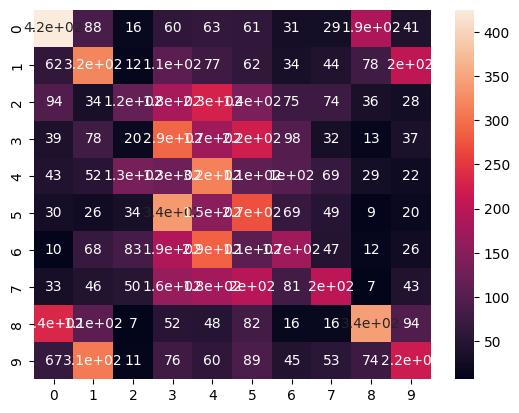

In [201]:
from keras.models import load_model
disc_sup_trained_model = load_model('/content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/disc_sup.h5')

(_, _), (testX, testy) = load_data()

# testX = expand_dims(testX, axis=-1)

testX = testX.astype('float32')

testX = (testX - 127.5) / 127.5

testy = np.squeeze(testy)

_, test_acc = disc_sup_trained_model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

y_pred_test = disc_sup_trained_model.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(testy, prediction_test)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 460ms/step


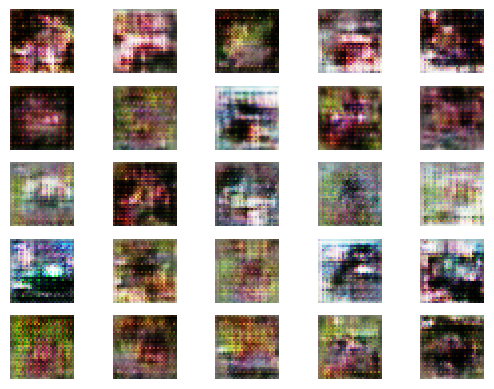

In [203]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :], cmap='gray')
	plt.show()

gen_trained_model = load_model('/content/drive/MyDrive/Colab Notebooks/Researchs/SGAN/gen_model.h5') #Model trained for 100 epochs
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
X = gen_trained_model.predict(latent_points)
X = (X + 1) / 2.0

X = (X*255).astype(np.uint8)

show_plot(X, 5)